In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay

In [2]:
EXAM_NAMES = ['Kuis 2', 'UTS']
EXAM_NUMBERS = {
    'Kuis 2': ['IA', 'IB', 'IC'],
    'UTS': ['IA', 'IB']
}
EXAMS = []
for exam_name in EXAM_NAMES:
    for exam_number in EXAM_NUMBERS[exam_name]:
        EXAMS.append((exam_name, exam_number))

LB = {
    'All': 0.6562801963,
    'Kuis 2 IA': 0.1447276516,
    'Kuis 2 IB': 0.3178719202,
    'Kuis 2 IC': 0.6346878475,
    'UTS IA': 0.5107134316,
    'UTS IB': 0.4047760493
}

X_AXIS = 'nilai autograder'
Y_AXIS = 'nilai manual'
EPS = 0.001

import os 
import sys

module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path) 
    
from grader.src.ged.classes.general_cost_function import RelabelMethod
from grader.src.grader import Grader, GraphPreprocessType

REAL_GRADE_FILENAME = 'Real Results.csv' 
AFILE_PREFIX = 'Grade_'

real_dataframe = pd.read_csv(REAL_GRADE_FILENAME)
dataframes = {}
for node_cost in range(1, 4):
    for edge_cost in range(1, 4):
        if node_cost == edge_cost and node_cost != 1:
            continue
        for relabel_method in RelabelMethod.__iter__():
            for graph_preprocess_type in GraphPreprocessType.__iter__():
                for pref in ['', 'APR_']:
                    filename = f'{pref}Grade_{relabel_method.name}_{graph_preprocess_type.name}_C{node_cost}{edge_cost}.csv'
                    if filename not in os.listdir('./'):
                        continue
                    dataframes[filename] = pd.read_csv(filename).rename(columns={'grade': 'nilai autograder'})
                    dataframes[filename] = pd.merge(dataframes[filename], real_dataframe, on=['nim', 'exam_name', 'number'])
                    
SENDJAJA = 'Grade Results.csv'
dataframes[SENDJAJA] = pd.read_csv(SENDJAJA).rename(columns={'grade': 'nilai autograder'})
dataframes[SENDJAJA] = pd.merge(dataframes[SENDJAJA], real_dataframe, on=['nim', 'exam_name', 'number'])

In [3]:
def merge_data(filename1, filename2, df1=None, df2=None):
    if isinstance(filename1, str):
        df1 = pd.read_csv(filename1)
    if isinstance(filename2, str):
        df2 = pd.read_csv(filename2)
    df1['grade'] = (np.array(df1['grade']) + np.array(df2['grade'])) / 2
    return df1

pair1 = 'Grade_BOOLEAN_COUNT_UNCOLLAPSE_C31.csv'
pair2 = 'Grade_NONE_COLLAPSE_NBE_C31.csv'
dataframes['merged_data.csv'] = merge_data(pair1, pair2).rename(columns={'grade': 'nilai autograder'})
dataframes['merged_data.csv'] = pd.merge(dataframes['merged_data.csv'], real_dataframe, on=['nim', 'exam_name', 'number'])

# pair11 = 'Grade_BOOLEAN_COUNT_UNCOLLAPSE_C31.csv'
# pair21 = 'APR_Grade_NONE_COLLAPSE_NBE_C13.csv'
# pair22 = 'APR_Grade_NONE_COLLAPSE_C31.csv'
# dataframes['merged_data2.csv'] = merge_data(pair11, None, df2=merge_data(pair21, pair22)).rename(columns={'grade': 'nilai autograder'})
# dataframes['merged_data2.csv'] = pd.merge(dataframes['merged_data2.csv'], real_dataframe, on=['nim', 'exam_name', 'number'])

In [4]:
# Correlation function
def correlation(df):
    return df.corr()

In [5]:
# MAE (Mean Absolute Error) function
def mae(df):
    return mean_absolute_error(df[X_AXIS], df[Y_AXIS])

In [6]:
# Linear Regression Plot function
def linear_regression_plot(name, df):
    m, b = np.polyfit(df[X_AXIS], df[Y_AXIS], 1)
    print(f'Info for plot={name}: m={m}, b={b}')
    fig, ax = plt.subplots(figsize=(8, 8), dpi=60)
    ax.scatter(df[X_AXIS], df[Y_AXIS])
#     ax.set_title(f'Perbandingan Hasil Penilaian Menggunakan Sistem Autograder\n dan Hasil Penilaian Manual oleh Pendidik\n{name}')
#     ax.set_xlabel('Hasil Penilaian Menggunakan Sistem Autograder')
#     ax.set_ylabel('Hasil Penilaian Manual oleh Pendidik')
    ax.set_xlabel('Hasil Penilaian Autograder')
    ax.set_ylabel('Hasil Penilaian Manual')
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    ax.set_aspect(1)
    ax.plot(df[Y_AXIS], m * df[Y_AXIS] + b)
    plt.show()

In [7]:
# Confusion Matrix Plot function
def confusion_matrix_plot(name, df):
    bins = [10 * x - EPS for x in range(11)] + [100 + EPS]
    labels = range(11)

    cat_X = pd.cut(df[X_AXIS], bins=bins, labels=labels)
    cat_Y = pd.cut(df[Y_AXIS], bins=bins, labels=labels)
    categorized_grade = pd.concat([cat_X, cat_Y], axis=1)
    
#     cm = confusion_matrix(categorized_grade[X_AXIS], categorized_grade[Y_AXIS], labels=labels)
    cm = confusion_matrix(categorized_grade[Y_AXIS], categorized_grade[X_AXIS], labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(10, 8), dpi=60)
#     ax.set_title(f'Confusion Matrix Perbandingan Hasil Penilaian Menggunakan Sistem Autograder\n dan Hasil Penilaian Manual oleh Pendidik\n{name}')
    
    ax.set_title(f'Confusion Matrix Perbandingan Hasil Penilaian Autograder\n dan Hasil Penilaian Manual')
    disp.plot(ax=ax)
    disp.ax_.set(xlabel=X_AXIS, ylabel=Y_AXIS)
    plt.show()

In [8]:
# Histogram Difference Plot Function
def histogram_dif_plot(name, df):
    n, bins, patches = plt.hist(x=df, bins='auto', rwidth=0.75)
    plt.grid(axis='y', alpha=0.80)
#     plt.title(f'Histogram Perbedaan Nilai Autograder dengan Nilai Manual\n{name}')
    plt.title(f'Histogram Perbedaan Nilai Autograder dengan Nilai Manual')
    plt.xlabel('Nilai Perbedaan = Nilai Autograder - Nilai Manual')
    plt.ylabel('Frekuensi')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    plt.show()

In [9]:
# Print Correlations
all_correls = {}
correls = []
for name, df in dataframes.items():
    corr = correlation(df)
    correls.append((corr[X_AXIS][Y_AXIS], name))
    all_correls[name] = {}
    all_correls[name]['All'] = corr[X_AXIS][Y_AXIS]
    
correls.sort(key=lambda x: -x[0])
for corr, name in correls:
    print(f'{name: <45}: {round(corr, 4)}')

merged_data.csv                              : 0.7576
Grade_NONE_UNCOLLAPSE_C31.csv                : 0.7417
Grade_NONE_UNCOLLAPSE_C21.csv                : 0.7399
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C31.csv       : 0.7358
Grade_NONE_UNCOLLAPSE_C32.csv                : 0.735
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C21.csv       : 0.7319
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C32.csv       : 0.7266
Grade_NONE_UNCOLLAPSE_C11.csv                : 0.7238
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C11.csv       : 0.7237
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C23.csv       : 0.7177
Grade_NONE_UNCOLLAPSE_C23.csv                : 0.7133
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C12.csv       : 0.7107
Grade_NONE_UNCOLLAPSE_C12.csv                : 0.7057
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C13.csv       : 0.7015
Grade_DAMERAU_LD_COLLAPSE_NBE_C32.csv        : 0.6974
Grade_COUNTER_COLLAPSE_NBE_C21.csv           : 0.6971
Grade_NONE_UNCOLLAPSE_C13.csv                : 0.6965
Grade_NONE_COLLAPSE_NBE_C31.csv              : 0.6957
Grade_NONE_COLLAPSE_NBE_C21.c

In [10]:
exam_correls = {}
for exam in EXAMS:
    exam_correls[exam] = []
    for _, name in correls:
        df = dataframes[name]
        corr = correlation(df.loc[(df['exam_name'] == exam[0]) & (df['number'] == exam[1])])
        exam_correls[exam].append((corr[X_AXIS][Y_AXIS], name))
        all_correls[name][f'{exam[0]} {exam[1]}'] = corr[X_AXIS][Y_AXIS]
    exam_correls[exam].sort(reverse=True)
    
for exam in EXAMS:
    print('-----')
    for corr, name in exam_correls[exam][:10]:
        print(f'{exam} {name}: {corr}')
    print('-----\n')

-----
('Kuis 2', 'IA') Grade_COUNTER_COLLAPSE_NBE_C21.csv: 0.16404346947885512
('Kuis 2', 'IA') Grade_DAMERAU_LD_COLLAPSE_NBE_C21.csv: 0.16309783162456343
('Kuis 2', 'IA') Grade_BOOLEAN_COUNT_COLLAPSE_NBE_C21.csv: 0.1628416868034738
('Kuis 2', 'IA') Grade_NONE_COLLAPSE_NBE_C31.csv: 0.16256624945673817
('Kuis 2', 'IA') Grade_EXACT_COLLAPSE_NBE_C21.csv: 0.1597390127315017
('Kuis 2', 'IA') Grade_DAMERAU_LD_COLLAPSE_NBE_C31.csv: 0.15943973572028738
('Kuis 2', 'IA') Grade_COUNTER_COLLAPSE_NBE_C31.csv: 0.15911736588829503
('Kuis 2', 'IA') Grade_COUNTER_COLLAPSE_NBE_C32.csv: 0.158215433436987
('Kuis 2', 'IA') Grade_NONE_COLLAPSE_NBE_C21.csv: 0.1579567352809037
('Kuis 2', 'IA') Grade_BOOLEAN_COUNT_COLLAPSE_NBE_C31.csv: 0.15759692270459671
-----

-----
('Kuis 2', 'IB') Grade_BOOLEAN_COUNT_UNCOLLAPSE_C23.csv: 0.6031040549564886
('Kuis 2', 'IB') Grade_BOOLEAN_COUNT_UNCOLLAPSE_C12.csv: 0.600841574129304
('Kuis 2', 'IB') Grade_BOOLEAN_COUNT_UNCOLLAPSE_C11.csv: 0.5978581601933446
('Kuis 2', 'IB') Gr

In [11]:
count_top = {}
for exam in EXAMS:
    for corr, name in exam_correls[exam]:
        if corr >= LB[f'{exam[0]} {exam[1]}'] * 0.8:
            if name not in count_top:
                count_top[name] = 0
            count_top[name] += 1
    
top_name = [x for x in count_top.items()]
top_name.sort(reverse=True, key=lambda x: (x[1], all_correls[x[0]]['All']))
vis = {}
for name, count in top_name:
    if count not in vis:
        vis[count] = 0
    if vis[count] >= 20:
        continue
    print(f'{name}: {count}')
    for exam, corr in all_correls[name].items():
        print(f'{exam}: {corr}')
    print()
    vis[count] += 1

APR_Grade_DAMERAU_LD_COLLAPSE_NBE_C32.csv: 5
All: 0.6684279448690417
Kuis 2 IA: 0.13766418223429272
Kuis 2 IB: 0.36751476167742914
Kuis 2 IC: 0.6350158331818712
UTS IA: 0.490409149555743
UTS IB: 0.3827626692037839

APR_Grade_COUNTER_COLLAPSE_NBE_C21.csv: 5
All: 0.6682908589048888
Kuis 2 IA: 0.13575464179595856
Kuis 2 IB: 0.36365702865049193
Kuis 2 IC: 0.6401666932335918
UTS IA: 0.4757105587107241
UTS IB: 0.3693907625512148

APR_Grade_DAMERAU_LD_COLLAPSE_NBE_C21.csv: 5
All: 0.6679362780747657
Kuis 2 IA: 0.13745632666187996
Kuis 2 IB: 0.36459474351581794
Kuis 2 IC: 0.6383366627011972
UTS IA: 0.4849583326065415
UTS IB: 0.3764695939213648

APR_Grade_COUNTER_COLLAPSE_NBE_C32.csv: 5
All: 0.6677997364615115
Kuis 2 IA: 0.1360295450149784
Kuis 2 IB: 0.36598457873872675
Kuis 2 IC: 0.6356917982016161
UTS IA: 0.4819394937384448
UTS IB: 0.37674625495390657

APR_Grade_COUNTER_COLLAPSE_NBE_C11.csv: 5
All: 0.6661078543674824
Kuis 2 IA: 0.13590547585933138
Kuis 2 IB: 0.3641875871745875
Kuis 2 IC: 0.630

In [12]:
# Print MAE
# for name, df in dataframes.items():
#     print(f'MAE (Mean Absolute Error) of dataframe {name} exam: {mae(df)}')
    
# maes = []
# for name, df in dataframes.items():
#     maes.append((mae(df), name))
# maes.sort()
# for mae, name in maes:
#     print(f'{name}: {mae}')

for _, name in [(all_correls[SENDJAJA]['All'], SENDJAJA)] + correls[:10]:
    df = dataframes[name]
    print(f'{name: <45}: {round(mae(df), 4)}')

Grade Results.csv                            : 13.1087
merged_data.csv                              : 11.5711
Grade_NONE_UNCOLLAPSE_C31.csv                : 12.295
Grade_NONE_UNCOLLAPSE_C21.csv                : 11.3648
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C31.csv       : 10.7172
Grade_NONE_UNCOLLAPSE_C32.csv                : 11.1078
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C21.csv       : 10.4082
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C32.csv       : 10.5789
Grade_NONE_UNCOLLAPSE_C11.csv                : 11.8805
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C11.csv       : 11.8728
Grade_BOOLEAN_COUNT_UNCOLLAPSE_C23.csv       : 14.4992


Linear Regression Plot of Grade Results.csv exam:
Info for plot=Grade Results.csv: m=0.6494050079710322, b=19.19245395383932


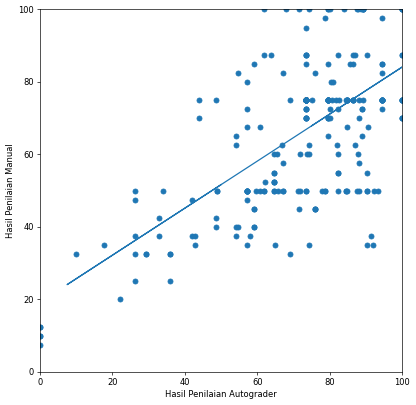

Linear Regression Plot of merged_data.csv exam:
Info for plot=merged_data.csv: m=0.9500856834598624, b=-2.8340382365768693


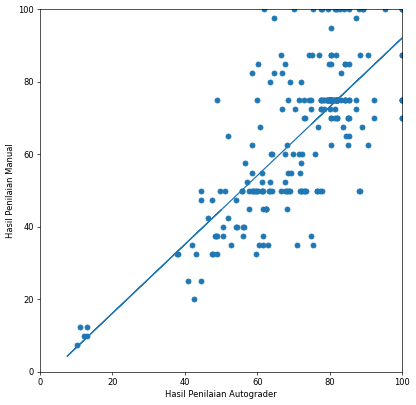

Linear Regression Plot of Grade_NONE_UNCOLLAPSE_C31.csv exam:
Info for plot=Grade_NONE_UNCOLLAPSE_C31.csv: m=0.817998122566247, b=6.690146414620903


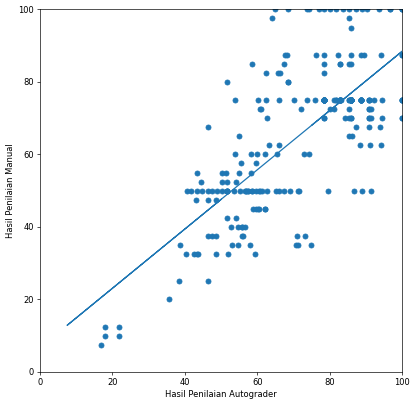

Linear Regression Plot of Grade_NONE_UNCOLLAPSE_C21.csv exam:
Info for plot=Grade_NONE_UNCOLLAPSE_C21.csv: m=0.7521148015557135, b=14.19529434670955


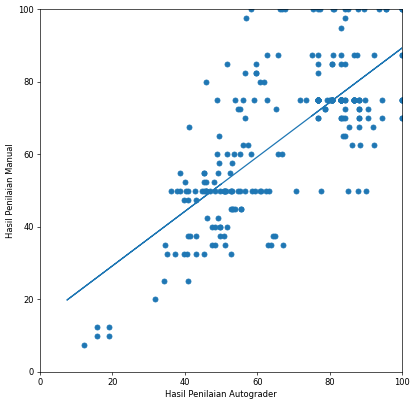

Linear Regression Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C31.csv exam:
Info for plot=Grade_BOOLEAN_COUNT_UNCOLLAPSE_C31.csv: m=0.8627414976230011, b=6.442975860159034


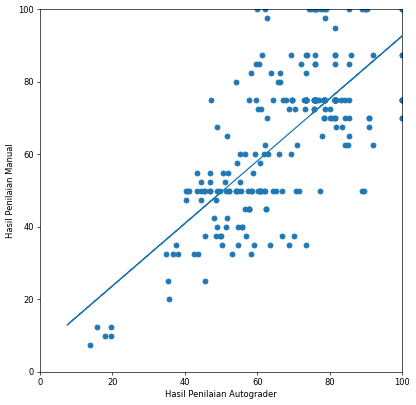

Linear Regression Plot of Grade_NONE_UNCOLLAPSE_C32.csv exam:
Info for plot=Grade_NONE_UNCOLLAPSE_C32.csv: m=0.7023706726910965, b=19.595557673633444


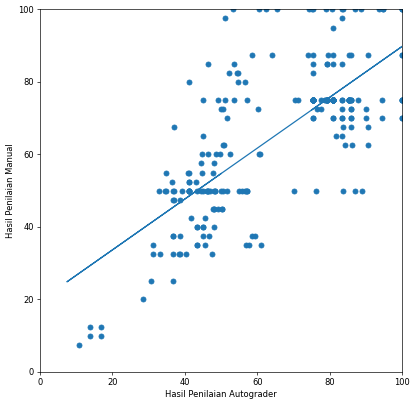

Linear Regression Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C21.csv exam:
Info for plot=Grade_BOOLEAN_COUNT_UNCOLLAPSE_C21.csv: m=0.7997091746715691, b=13.669483336722955


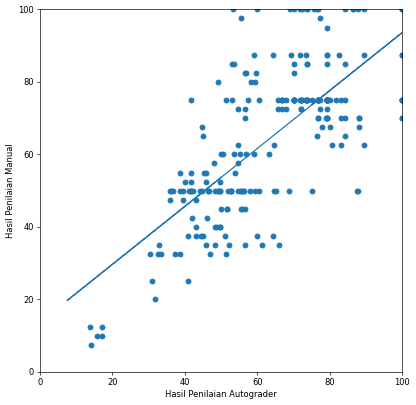

Linear Regression Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C32.csv exam:
Info for plot=Grade_BOOLEAN_COUNT_UNCOLLAPSE_C32.csv: m=0.7461649632536433, b=19.05397075489182


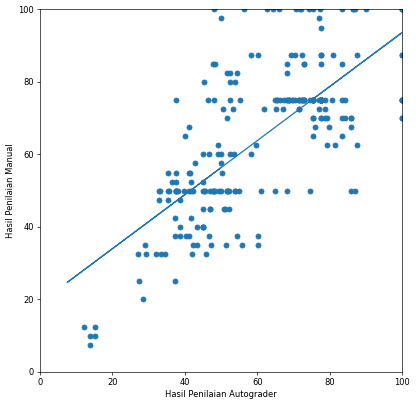

Linear Regression Plot of Grade_NONE_UNCOLLAPSE_C11.csv exam:
Info for plot=Grade_NONE_UNCOLLAPSE_C11.csv: m=0.6347270501176049, b=26.644043010739313


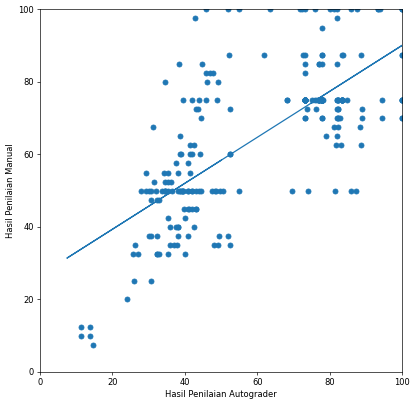

Linear Regression Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C11.csv exam:
Info for plot=Grade_BOOLEAN_COUNT_UNCOLLAPSE_C11.csv: m=0.6758535407572583, b=25.9468026620686


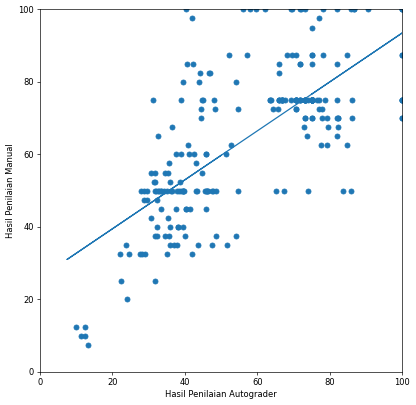

Linear Regression Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C23.csv exam:
Info for plot=Grade_BOOLEAN_COUNT_UNCOLLAPSE_C23.csv: m=0.6109664675038544, b=31.885150372559792


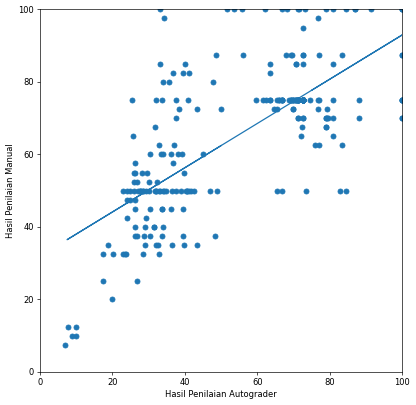

In [13]:
for _, name in [(all_correls[SENDJAJA]['All'], SENDJAJA)] + correls[:10]:
    df = dataframes[name]
    print(f'Linear Regression Plot of {name} exam:')
    linear_regression_plot(name, df)

Confusion Matrix Plot of Grade Results.csv exam:


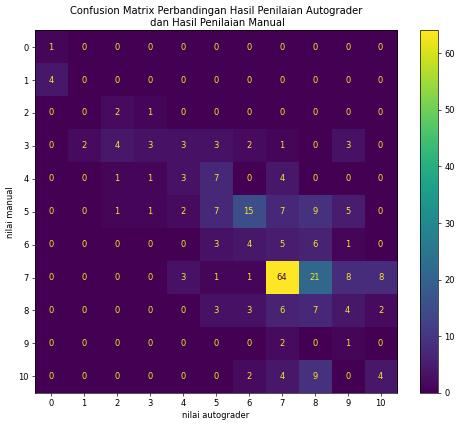

Confusion Matrix Plot of merged_data.csv exam:


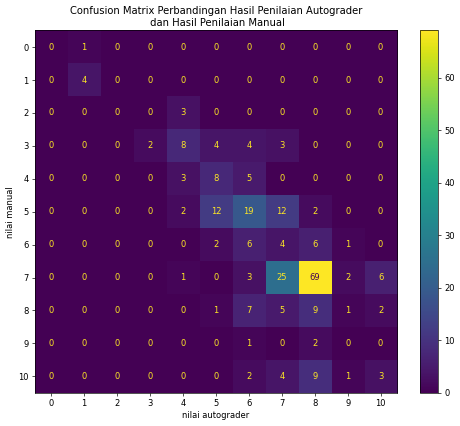

Confusion Matrix Plot of Grade_NONE_UNCOLLAPSE_C31.csv exam:


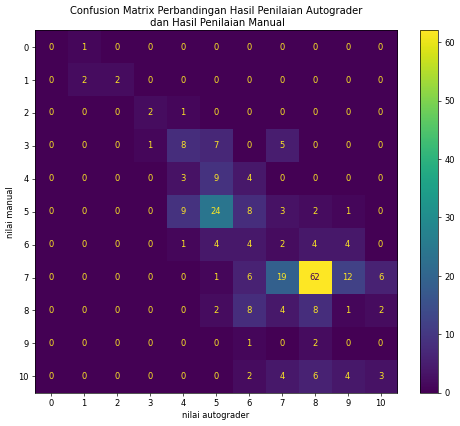

Confusion Matrix Plot of Grade_NONE_UNCOLLAPSE_C21.csv exam:


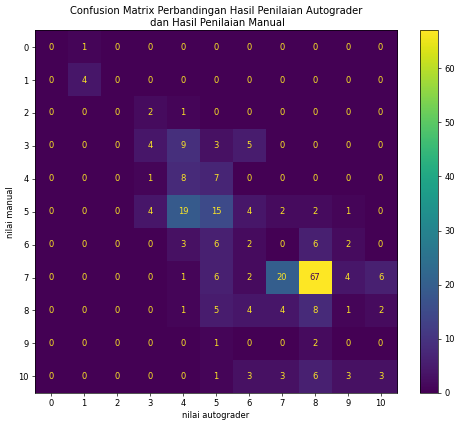

Confusion Matrix Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C31.csv exam:


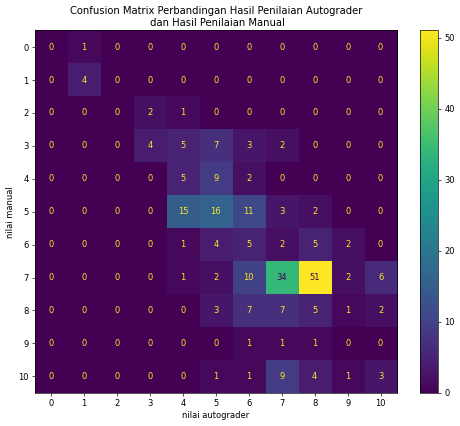

Confusion Matrix Plot of Grade_NONE_UNCOLLAPSE_C32.csv exam:


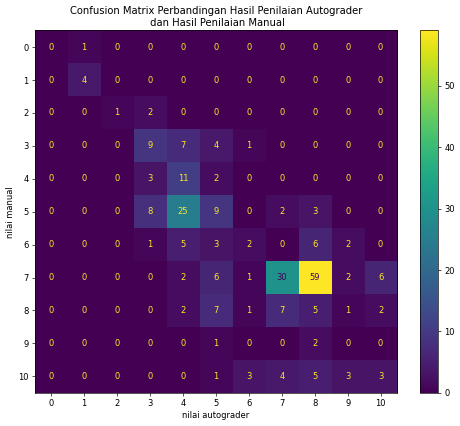

Confusion Matrix Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C21.csv exam:


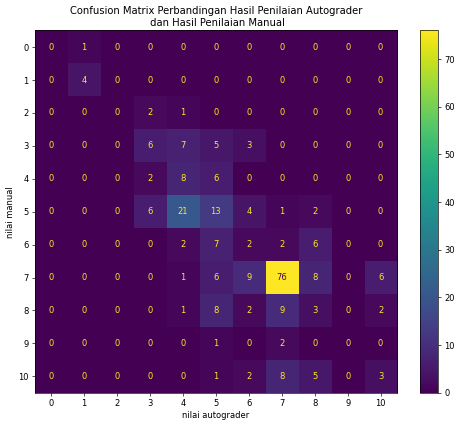

Confusion Matrix Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C32.csv exam:


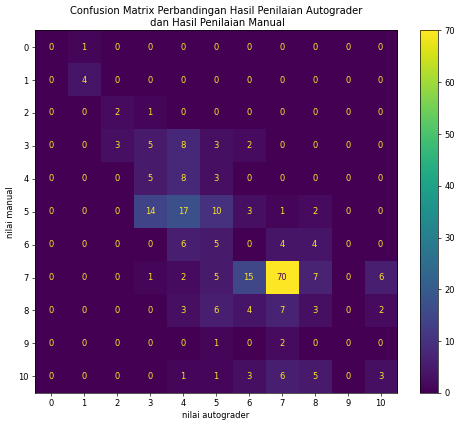

Confusion Matrix Plot of Grade_NONE_UNCOLLAPSE_C11.csv exam:


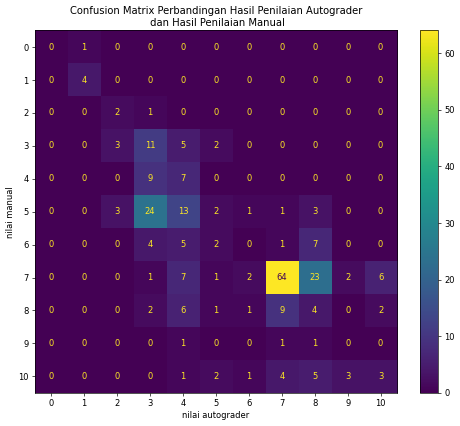

Confusion Matrix Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C11.csv exam:


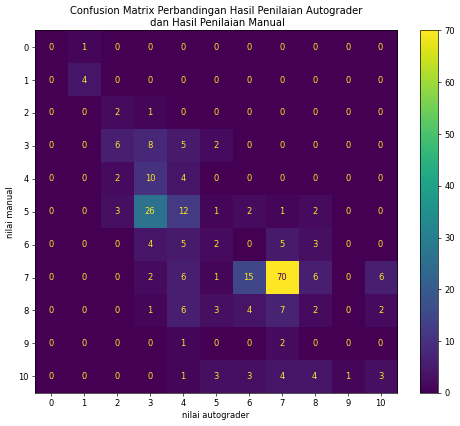

Confusion Matrix Plot of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C23.csv exam:


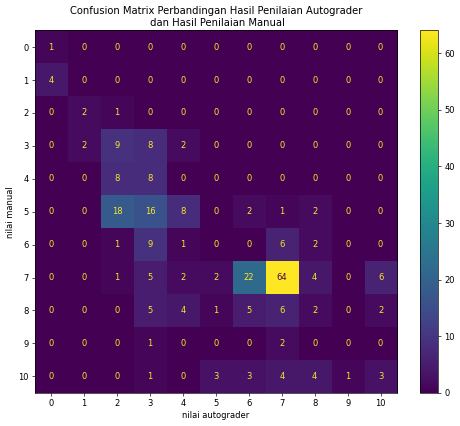

In [14]:
for _, name in [(all_correls[SENDJAJA]['All'], SENDJAJA)] + correls[:10]:
    df = dataframes[name]
    print(f'Confusion Matrix Plot of {name} exam:')
    confusion_matrix_plot(name, df)

Information on Difference of Grade Results.csv exam:
Average 		:  5.8905
Standard Deviation	:  16.3981
Histogram Plot:


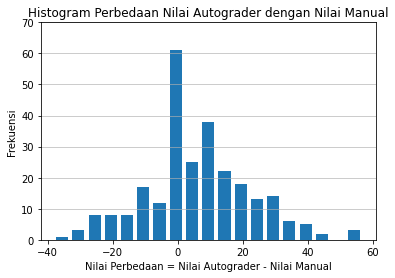

Information on Difference of merged_data.csv exam:
Average 		:  6.4321
Standard Deviation	:  12.8648
Histogram Plot:


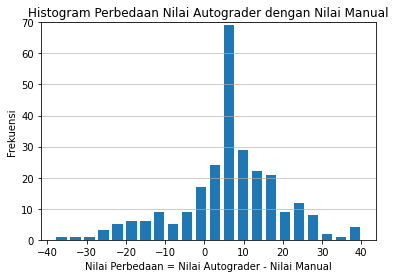

Information on Difference of Grade_NONE_UNCOLLAPSE_C31.csv exam:
Average 		:  6.429
Standard Deviation	:  13.5878
Histogram Plot:


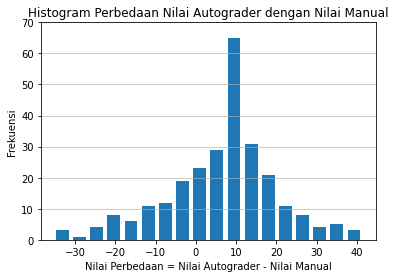

Information on Difference of Grade_NONE_UNCOLLAPSE_C21.csv exam:
Average 		:  2.7645
Standard Deviation	:  14.0769
Histogram Plot:


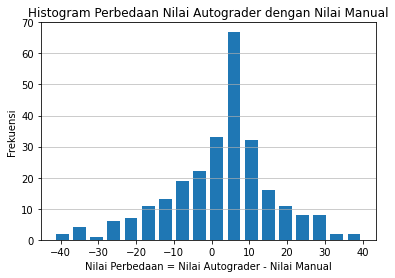

Information on Difference of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C31.csv exam:
Average 		:  2.9772
Standard Deviation	:  13.5193
Histogram Plot:


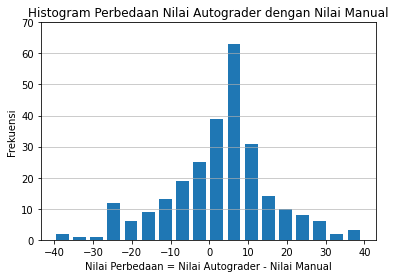

Information on Difference of Grade_NONE_UNCOLLAPSE_C32.csv exam:
Average 		:  -0.0786
Standard Deviation	:  14.6789
Histogram Plot:


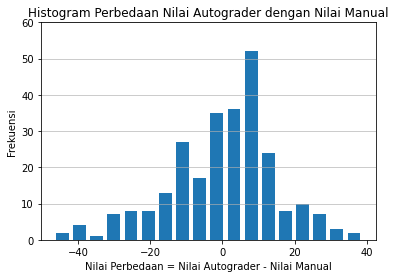

Information on Difference of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C21.csv exam:
Average 		:  -0.6499
Standard Deviation	:  13.8808
Histogram Plot:


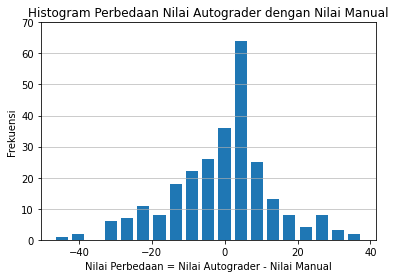

Information on Difference of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C32.csv exam:
Average 		:  -3.2015
Standard Deviation	:  14.3639
Histogram Plot:


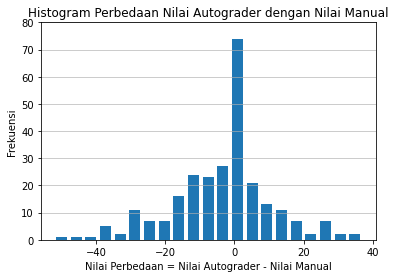

Information on Difference of Grade_NONE_UNCOLLAPSE_C11.csv exam:
Average 		:  -4.1949
Standard Deviation	:  15.8557
Histogram Plot:


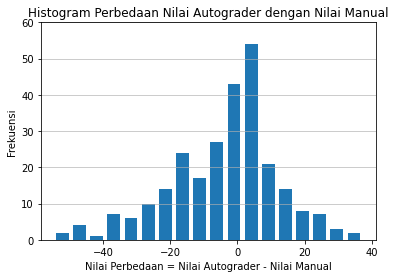

Information on Difference of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C11.csv exam:
Average 		:  -6.9031
Standard Deviation	:  15.1968
Histogram Plot:


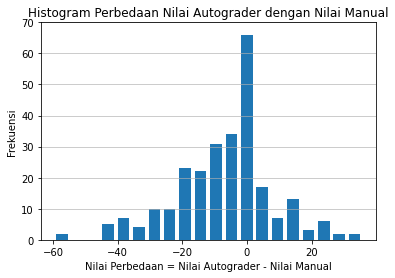

Information on Difference of Grade_BOOLEAN_COUNT_UNCOLLAPSE_C23.csv exam:
Average 		:  -10.3832
Standard Deviation	:  16.3851
Histogram Plot:


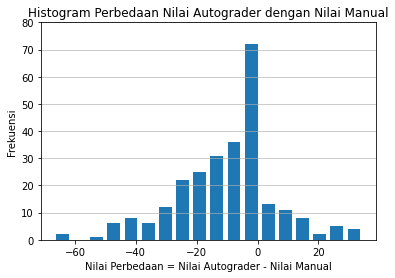

In [15]:
# Show Histogram Difference Plot
for corr, name in [(all_correls[SENDJAJA]['All'], SENDJAJA)] + correls[:10]:
    df = dataframes[name]
    print(f'Information on Difference of {name} exam:')
    df_dif = df[X_AXIS] - df[Y_AXIS]
    print('Average \t\t: ', round(df_dif.mean(), 4))
    print('Standard Deviation\t: ', round(df_dif.std(), 4))
    print('Histogram Plot:')
    histogram_dif_plot(name, df_dif)